In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas_datareader.data as web
import datetime
import numpy as np
from matplotlib import style
import matplotlib.dates as mdates
from tqdm import tqdm_notebook
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import os
import sys
import time
from matplotlib import pyplot as plt

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

style.use('ggplot')


In [3]:
# get 2011-2019 data to train our model
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2019,12,31)
df = web.DataReader("TSLA", 'yahoo', start, end)


In [4]:
# get 2020 data to test our model on
start = datetime.datetime(2020,1,2)
end = datetime.date.today()
test_df = web.DataReader("TSLA", 'yahoo', start, end)


In [5]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')


In [6]:
# # fix the date
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

df.head(30)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,5.000,3.508,3.800,4.778,93831500,4.778
2010-06-30,6.084,4.660,5.158,4.766,85935500,4.766
2010-07-01,5.184,4.054,5.000,4.392,41094000,4.392
2010-07-02,4.620,3.742,4.600,3.840,25699000,3.840
2010-07-06,4.000,3.166,4.000,3.222,34334500,3.222
2010-07-07,3.326,2.996,3.280,3.160,34608500,3.160
2010-07-08,3.504,3.114,3.228,3.492,38557000,3.492
2010-07-09,3.580,3.310,3.516,3.480,20253000,3.480
2010-07-12,3.614,3.400,3.590,3.410,11012500,3.410


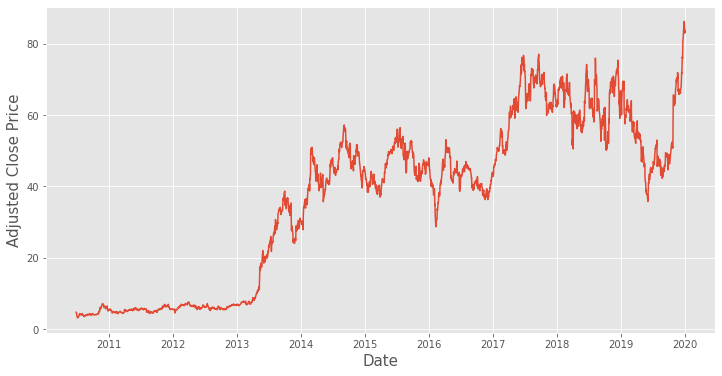

In [7]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()

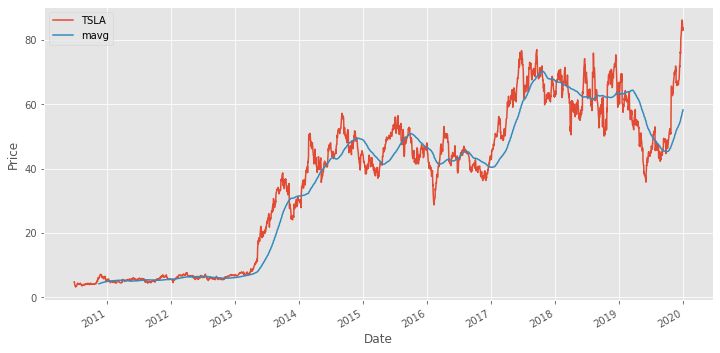

In [8]:
# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
plt.figure(figsize = (12,6))
close_px.plot(label='TSLA')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()


In [9]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,5.000,3.508,3.800,4.778,93831500,4.778
2010-06-30,6.084,4.660,5.158,4.766,85935500,4.766
2010-07-01,5.184,4.054,5.000,4.392,41094000,4.392
2010-07-02,4.620,3.742,4.600,3.840,25699000,3.840
2010-07-06,4.000,3.166,4.000,3.222,34334500,3.222


In [10]:
# change the dates into ints for training
dates_df = df.copy()
dates_df = dates_df.reset_index()

In [11]:
dates_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-06-29,5.000,3.508,3.800,4.778,93831500,4.778
1,2010-06-30,6.084,4.660,5.158,4.766,85935500,4.766
2,2010-07-01,5.184,4.054,5.000,4.392,41094000,4.392
3,2010-07-02,4.620,3.742,4.600,3.840,25699000,3.840
4,2010-07-06,4.000,3.166,4.000,3.222,34334500,3.222


In [12]:
# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

In [13]:
# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)
df = dates_df
dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
2389,18254.0,85.094002,82.538002,83.671997,85.050003,40273500,85.050003
2390,18256.0,86.695999,85.269997,85.582001,86.188004,53169500,86.188004
2391,18257.0,87.061996,85.222000,87.000000,86.075996,49728500,86.075996
2392,18260.0,85.800003,81.851997,85.758003,82.940002,62932000,82.940002
2393,18261.0,84.258003,80.416000,81.000000,83.666000,51428500,83.666000


In [14]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler
train_cols = ['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df.loc[:,train_cols].values)

In [15]:
train_data[30]

array([0.01238479, 0.00537403, 0.00697669, 0.00608795, 0.00505853,
       0.01833156, 0.00505853])

In [16]:
print(df.columns)

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')


In [17]:
'''Function to create a timeseries data to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 4])
    return np.array(dataX), np.array(dataY)

In [18]:
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)


In [19]:
train_data[36,4]

0.007202386981427229

In [20]:
print(X_train)

[[[0.00000000e+00 1.99914027e-02 6.22310653e-03 ... 1.94873985e-02
   5.03376937e-01 1.94873985e-02]
  [2.88018433e-04 3.29368521e-02 2.02250998e-02 ... 1.93428680e-02
   4.60748163e-01 1.93428680e-02]
  [5.76036866e-04 2.21887852e-02 1.28594683e-02 ... 1.48383685e-02
   2.18658727e-01 1.48383685e-02]
  ...
  [1.38248848e-02 5.18295636e-03 7.97335642e-03 ... 7.17830047e-03
   9.91486122e-03 7.17830047e-03]
  [1.41129032e-02 6.61603328e-03 9.23742643e-03 ... 8.06956460e-03
   8.89179223e-03 8.06956460e-03]
  [1.44009217e-02 7.06983893e-03 8.79986396e-03 ... 7.15421108e-03
   1.30326572e-02 7.15421108e-03]]

 [[2.88018433e-04 3.29368521e-02 2.02250998e-02 ... 1.93428680e-02
   4.60748163e-01 1.93428680e-02]
  [5.76036866e-04 2.21887852e-02 1.28594683e-02 ... 1.48383685e-02
   2.18658727e-01 1.48383685e-02]
  [8.64055300e-04 1.54533291e-02 9.06726405e-03 ... 8.19000578e-03
   1.35544494e-01 8.19000578e-03]
  ...
  [1.41129032e-02 6.61603328e-03 9.23742643e-03 ... 8.06956460e-03
   8.89179

In [21]:
print(y_train)

[0.00720239 0.00794912 0.01043022 ... 0.99865097 0.96088066 0.96962467]


In [22]:
## # reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 7))

In [23]:
# Build the model
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 7)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

In [24]:
# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [25]:
# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 100, batch_size = 10, validation_split=.30)

Epoch 1/100
165/165 [==============================] - 18s 59ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 2/100
165/165 [==============================] - 9s 52ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 3/100
165/165 [==============================] - 8s 49ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 4/100
165/165 [==============================] - 8s 49ms/step - loss: 0.0011 - val_loss: 0.0059
Epoch 5/100
165/165 [==============================] - 8s 49ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 6/100
165/165 [==============================] - 8s 49ms/step - loss: 9.2339e-04 - val_loss: 0.0015
Epoch 7/100
165/165 [==============================] - 8s 49ms/step - loss: 9.1238e-04 - val_loss: 0.0061
Epoch 8/100
165/165 [==============================] - 8s 50ms/step - loss: 8.7935e-04 - val_loss: 0.0049
Epoch 9/100
165/165 [==============================] - 8s 48ms/step - loss: 8.0076e-04 - val_loss: 0.0030
Epoch 10/100
165/165 [==============================] - 8s 47ms/s

165/165 [==============================] - 8s 50ms/step - loss: 3.7127e-04 - val_loss: 8.3550e-04
Epoch 78/100
165/165 [==============================] - 8s 50ms/step - loss: 3.6496e-04 - val_loss: 7.5476e-04
Epoch 79/100
165/165 [==============================] - 8s 50ms/step - loss: 3.5121e-04 - val_loss: 0.0020
Epoch 80/100
165/165 [==============================] - 8s 50ms/step - loss: 4.1785e-04 - val_loss: 0.0015
Epoch 81/100
165/165 [==============================] - 8s 50ms/step - loss: 3.4269e-04 - val_loss: 0.0037
Epoch 82/100
165/165 [==============================] - 8s 50ms/step - loss: 3.9099e-04 - val_loss: 0.0014
Epoch 83/100
165/165 [==============================] - 8s 50ms/step - loss: 3.5064e-04 - val_loss: 0.0020
Epoch 84/100
165/165 [==============================] - 8s 50ms/step - loss: 3.6465e-04 - val_loss: 7.2719e-04
Epoch 85/100
165/165 [==============================] - 8s 50ms/step - loss: 3.7878e-04 - val_loss: 0.0016
Epoch 86/100
165/165 [================

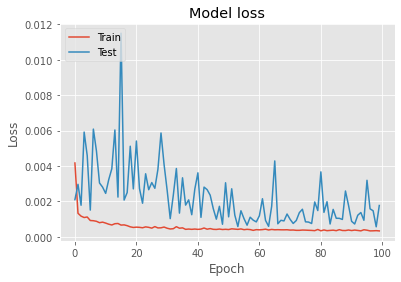

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36, 100)           43200     
                                                                 
 dropout (Dropout)           (None, 36, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 123,701
Trainable params: 123,701
Non-trainable params: 0
_________________________________________________________________


In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
model.summary()

In [27]:
test_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001
...,...,...,...,...,...,...
2022-07-18,751.549988,718.809998,734.809998,721.640015,27512500.0,721.640015
2022-07-19,741.419983,710.929993,735.000000,736.590027,26963400.0,736.590027
2022-07-20,751.989990,730.450012,740.349976,742.500000,29621400.0,742.500000


In [28]:
test_df = test_df.reset_index()
test_df['Date'] = test_df['Date'].map(mdates.date2num)
test_data = scaler.fit_transform(test_df.loc[:,train_cols].values)
print(test_data)

[[0.         0.00444552 0.0124161  ... 0.01192745 0.12838504 0.01192745]
 [0.00107296 0.00845407 0.01506848 ... 0.01413015 0.26820505 0.01413015]
 [0.00429185 0.00803428 0.01560557 ... 0.01560381 0.13857346 0.01560381]
 ...
 [0.99785408 0.57721084 0.57576874 ... 0.57897181 0.06721344 0.57897181]
 [0.99892704 0.63554112 0.60554467 ... 0.64170147 0.12731211 0.64170147]
 [1.         0.65494727 0.64699565 ... 0.64309218 0.08348983 0.64309218]]


In [29]:
# Create the data to test our model on:
# time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)
predicted_y = model.predict(X_test)
print(y_test)
print(predicted_y)

[0.07578869 0.0721417  0.05490012 0.05299802 0.06606395 0.06639048
 0.06707979 0.06276767 0.05912931 0.04263405 0.04908323 0.04716559
 0.03443653 0.03202996 0.01448604 0.01191708 0.         0.01147481
 0.0114558  0.01262367 0.02483963 0.03075671 0.02884079 0.02645668
 0.02434381 0.0281221  0.0207901  0.01610999 0.02052232 0.02678147
 0.03182783 0.03241349 0.0365874  0.05005416 0.06023671 0.06368158
 0.06633865 0.06783821 0.06653732 0.05623383 0.06407547 0.05950076
 0.06287305 0.07558829 0.07046938 0.07589236 0.07267381 0.05875615
 0.06909938 0.07031216 0.07279474 0.07235592 0.07915927 0.07775472
 0.07742993 0.07424248 0.07637954 0.07566085 0.07815898 0.07718807
 0.07849241 0.08057246 0.07872046 0.07906425 0.07929921 0.07680799
 0.08185089 0.09275213 0.08989466 0.09013652 0.08692663 0.09060299
 0.10170463 0.10010659 0.11468419 0.10566432 0.0991754  0.10878439
 0.10726927 0.10893815 0.11104066 0.110512   0.10937524 0.11066404
 0.10359291 0.10793441 0.10340115 0.11197184 0.12414461 0.1310

In [30]:
def mean_absolute_percentage_error_calc(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.divide(np.absolute(y_pred - y_true), y_true))

Scaled Error 0.10584015290444072
Mean absolute error (MAE):      0.022883
Mean absolute percentage error (MAE):      0.022883
Mean squared error (MSE):       0.001058


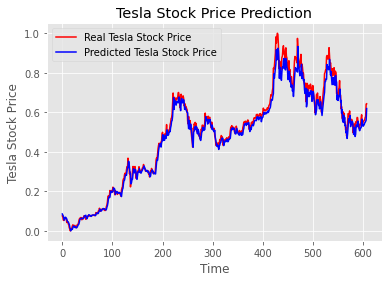

In [31]:
error = mean_squared_error(y_test, predicted_y)
scaled_error = (error/(np.max(y_test)-np.min(predicted_y)))*100
print("Scaled Error", scaled_error)
print("Mean absolute error (MAE):      %f" % mean_absolute_error(predicted_y,y_test))
print("Mean absolute percentage error (MAE):      %f" % mean_absolute_error(y_test,predicted_y))
print("Mean squared error (MSE):       %f" % mean_squared_error(predicted_y,y_test))
plt.plot(y_test, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()